#Author: SHALWIN A S
## Task-3
###Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.

#### Setting up the dataset from kaggle

In [9]:
!pip install kaggle pillow
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

In [10]:
# Kaggle API setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
# Download the dataset
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:08<00:00, 108MB/s] 
100% 812M/812M [00:08<00:00, 102MB/s]


In [12]:
# Unzip dataset
!unzip dogs-vs-cats.zip
!unzip train.zip -d /content/train/
!unzip test1.zip -d /content/test/

Streaming output truncated to the last 5000 lines.
  inflating: /content/test/test1/5499.jpg  
  inflating: /content/test/test1/55.jpg  
  inflating: /content/test/test1/550.jpg  
  inflating: /content/test/test1/5500.jpg  
  inflating: /content/test/test1/5501.jpg  
  inflating: /content/test/test1/5502.jpg  
  inflating: /content/test/test1/5503.jpg  
  inflating: /content/test/test1/5504.jpg  
  inflating: /content/test/test1/5505.jpg  
  inflating: /content/test/test1/5506.jpg  
  inflating: /content/test/test1/5507.jpg  
  inflating: /content/test/test1/5508.jpg  
  inflating: /content/test/test1/5509.jpg  
  inflating: /content/test/test1/551.jpg  
  inflating: /content/test/test1/5510.jpg  
  inflating: /content/test/test1/5511.jpg  
  inflating: /content/test/test1/5512.jpg  
  inflating: /content/test/test1/5513.jpg  
  inflating: /content/test/test1/5514.jpg  
  inflating: /content/test/test1/5515.jpg  
  inflating: /content/test/test1/5516.jpg  
  inflating: /content/test/te

In [38]:
# Define directories
train_dir = '/content/train/train'
test_dir = '/content/test/test1'

Preprocessing the dataset

In [14]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

Visualizing the dataset

In [15]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

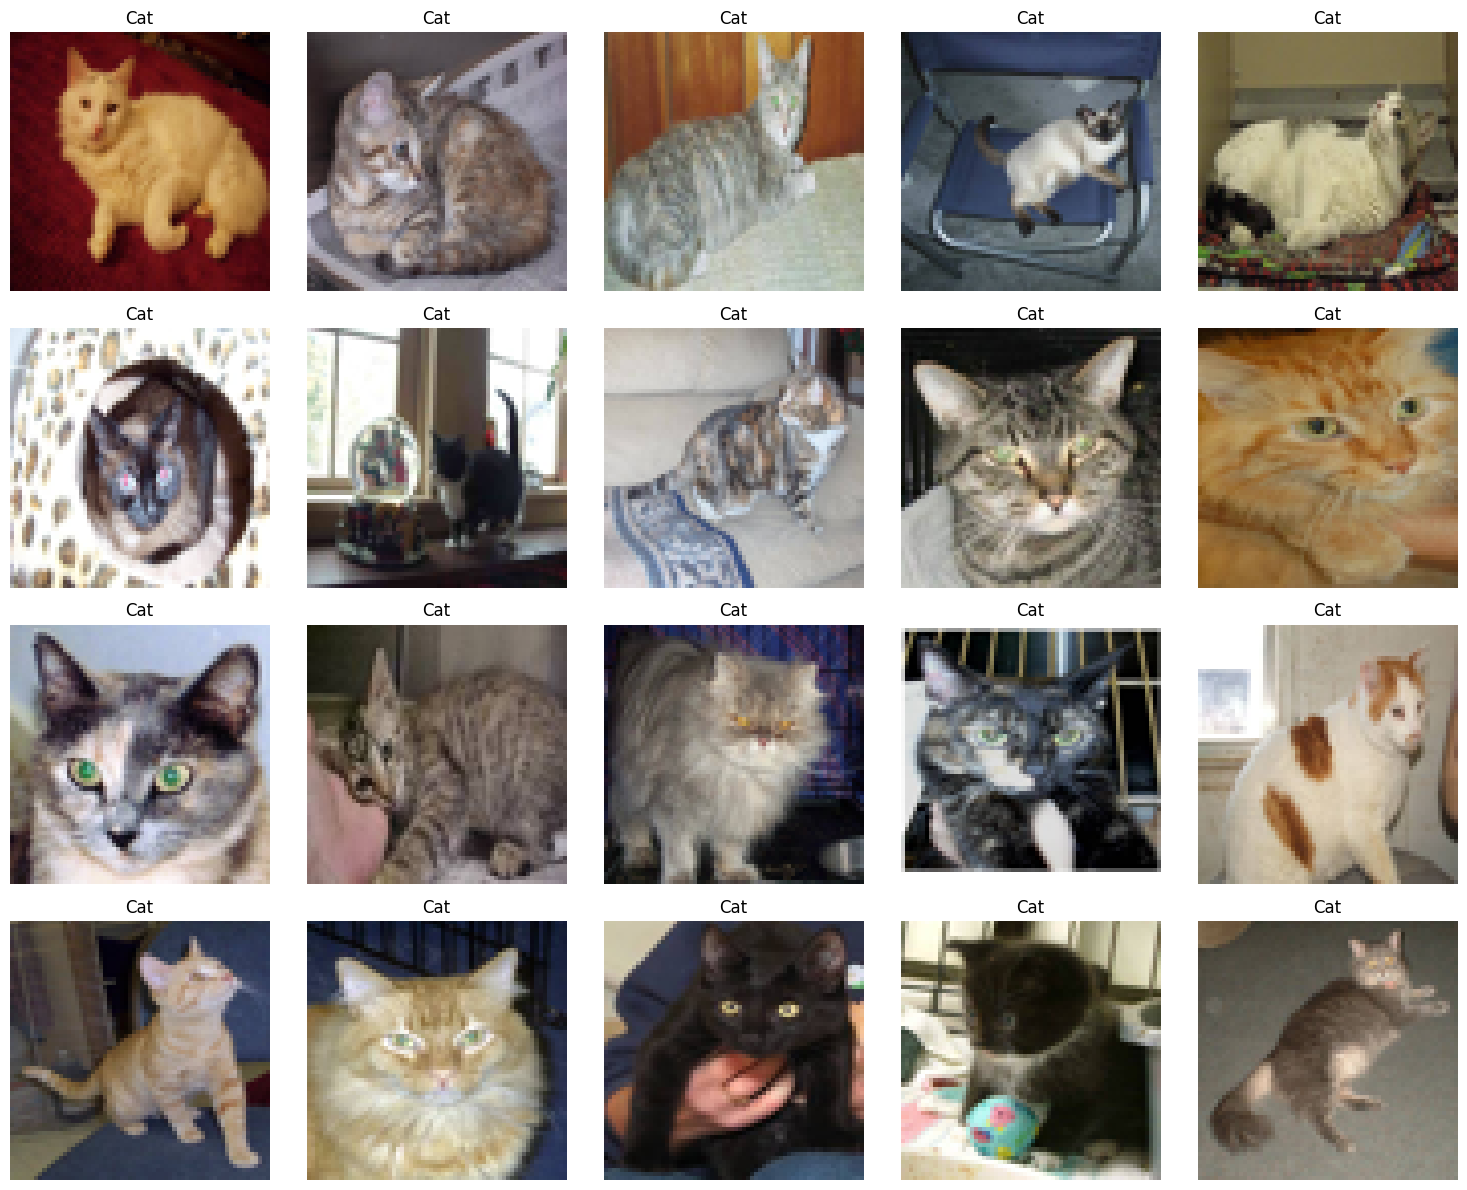

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load and visualize images
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=len(cat_images))

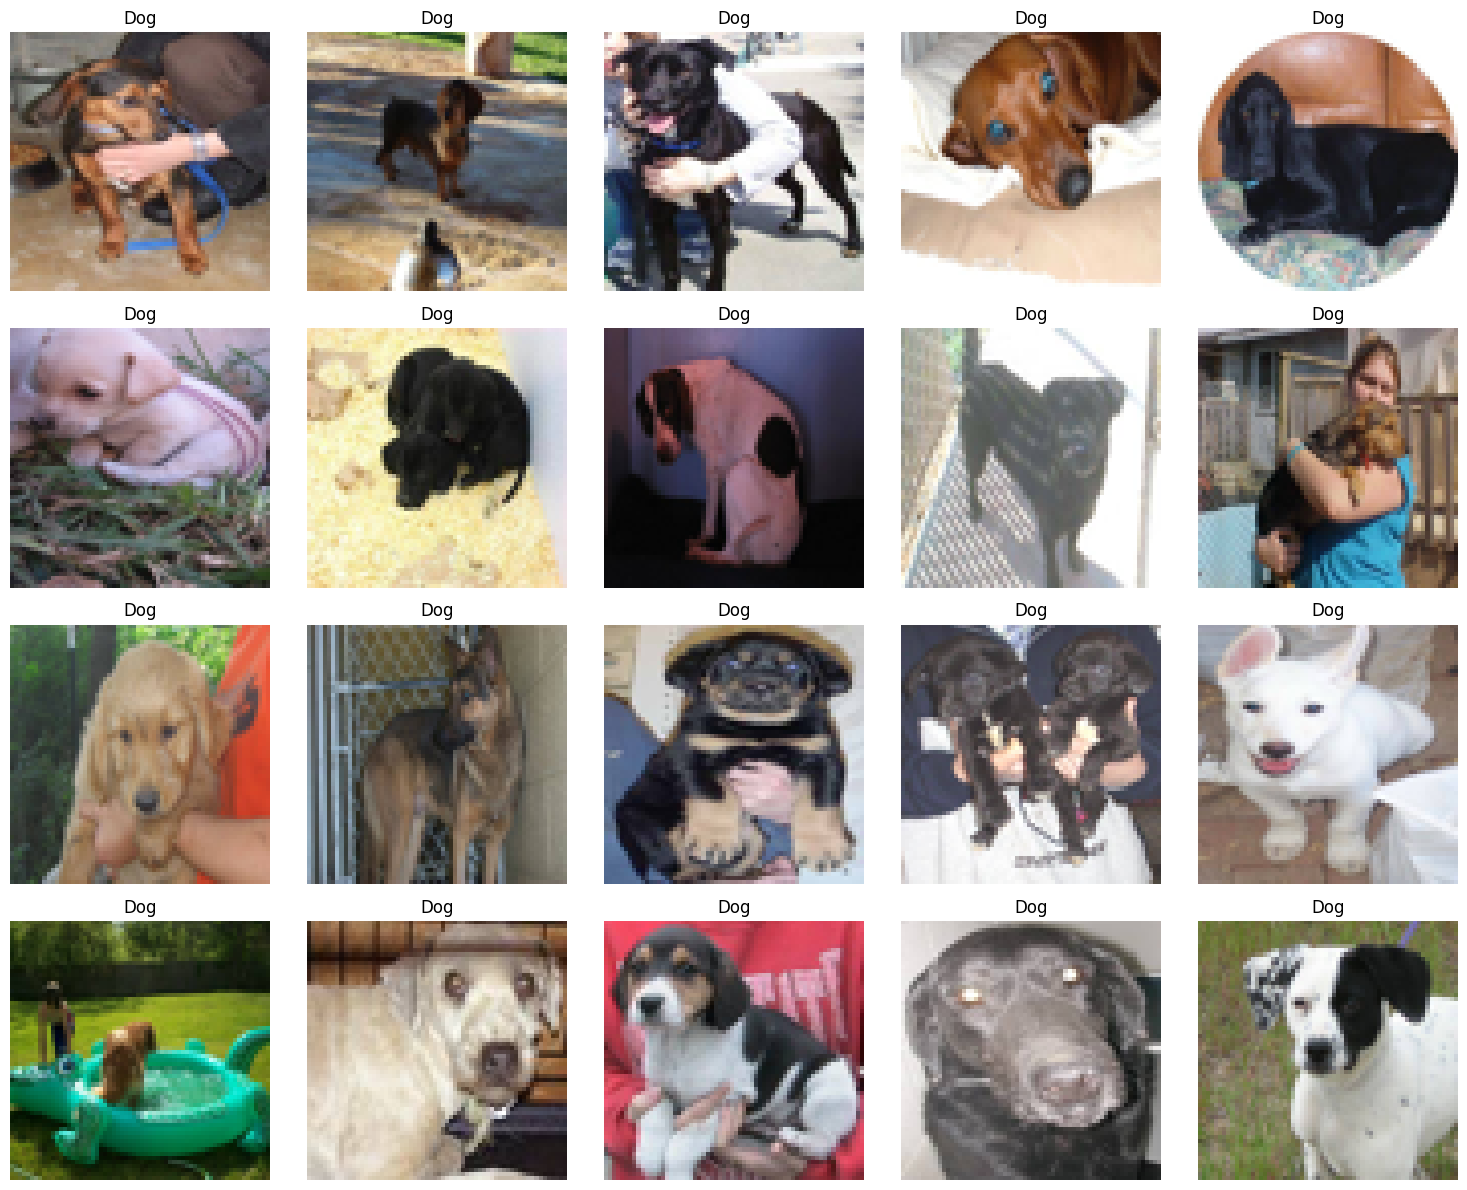

In [17]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

### Data preprocessing_ Train_dataset

In [18]:
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

In [19]:
# shape
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


In [20]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


#### Flattening

In [21]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

### Standardizing

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

t-SNE

In [23]:
from sklearn.manifold import TSNE

perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

### Splitting the dataset

In [24]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px

X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [25]:
X_train

array([[ 0.32820033,  0.37416723,  0.45113357, ..., -1.20263445,
        -1.14893531, -1.09746963],
       [ 1.53969242,  1.16307447,  0.81622835, ...,  1.4154894 ,
         1.21013504,  0.99199297],
       [-0.58398194, -0.6442403 , -0.68627708, ..., -0.41867646,
        -0.33233403, -0.0380238 ],
       ...,
       [ 1.45417533,  1.50732491,  0.74601782, ..., -0.92159291,
        -0.68014569, -0.67074839],
       [-0.48421201, -0.41474001, -0.50372969, ..., -1.06950951,
        -0.87673488, -0.77375007],
       [-1.43915283, -1.46183508, -1.33221399, ..., -1.39492603,
        -1.28503552, -1.05332605]])

In [26]:
X_val

array([[ 1.35440539,  1.76551273,  0.95664942, ..., -0.67013468,
        -0.52892323, -0.40588694],
       [-0.52697055, -0.94545943, -1.05137186, ..., -0.71450967,
        -1.07332408, -1.17104226],
       [-1.01156739, -0.87374059, -0.89690868, ..., -0.34471816,
        -0.33233403, -0.52360314],
       ...,
       [ 0.47072881,  0.48891738,  0.52134411, ...,  0.74986469,
         0.78671215,  0.80070414],
       [ 0.44222312,  0.51760491,  0.21241776, ..., -0.61096804,
         0.0759666 , -0.75903555],
       [ 0.98383134,  0.90488665,  0.31071251, ...,  1.25278114,
         0.68085643,  0.99199297]])

In [27]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4923, 1: 5077}


In [28]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

### model fit

In [29]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [30]:
y_val_pred = svm.predict(X_val)

In [31]:
y_val_pred

array([1, 0, 1, ..., 0, 1, 0])

### model evaluation

In [32]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [33]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5460


In [34]:
# classification report
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.55      0.59      0.57      1019
         Dog       0.54      0.50      0.52       981

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.54      2000
weighted avg       0.55      0.55      0.55      2000



Validation Confusion Matrix:
[[599 420]
 [488 493]]


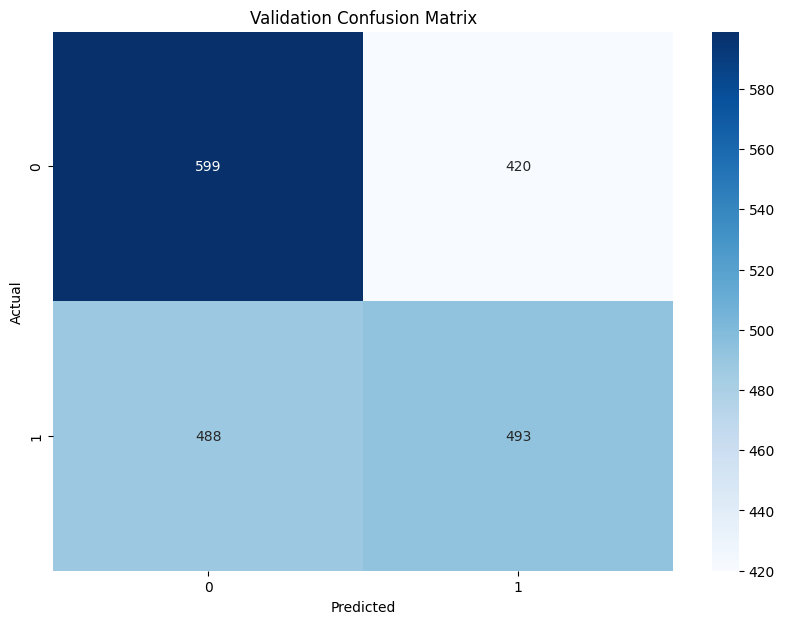

In [35]:
# Confusion metrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

### Saving the model

In [36]:
import pickle

with open('/content/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


### Preprocessing the Test data

In [39]:
# Loading the dataset
test_images, test_labels = load_images(test_dir)
test_images = test_images / 255.0

### Flattening

In [40]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

### Standardizing

In [41]:
test_images_flat_scaled = scaler.transform(test_images_flat)

### tSNE

In [42]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

### Prediction

In [43]:
y_test_pred = svm.predict(test_images_flat_scaled)

In [44]:
y_test_pred

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [46]:
# dataframe creation for the frame
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

In [47]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

In [48]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

### saving the file

In [49]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/content/test_predictions.csv', index=False)


In [50]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred)